In [1]:
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags

# Part 1: Heat distribution in anisotropic materials


**Plotting functions**

In [2]:
# Plotting numerical solution
def plot_solution(x, t, U, angle = 30 ,txt='Numerical Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={'projection' : '3d'})
    X, T = np.meshgrid(x,t)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(X, T, U, cmap=cm.coolwarm)
    ax.view_init(azim=angle)              # Rotate the figure
    plt.xlabel('y')
    plt.ylabel('x')
    plt.title(txt)
    
# Plotting the analytical solution
def plot_exact_solution(f,angle=30):
    M=100
    N=1000
    xs = np.linspace(0,1,M+1)
    ts = np.linspace(0,1,N+1)
    fig=plt.figure()
    ax = fig.gca(projection='3d')
    T,X = np.meshgrid(xs, ts) # grid of point
    Z = f(T, X) # evaluation of the function on the grid
    ax.plot_surface(X, T, Z, cmap=cm.coolwarm)
    ax.view_init(azim=angle)
    plt.title("Analytical solution")

**Implementation of the scheme in 1a**

In [3]:
def scheme1(a, g, RHS, M, N, T=1):
    '''
    input: constant a > 0,
           boundary function g,
           heat function/right hand side RHS
           M number of gridpoints in x-direction,
           N number of gridpoints in y-direction,
           T time
    '''
    
    # Initializing gridpoints in x-direction
    x_part = np.linspace(0, 1, M+1)
    x = np.zeros((M+1)*(M+1))
    i_vec = np.arange(0,len(x), M+1)
    for i in i_vec:
        x[i:(i+M+1)] = x_part
    
    # Initializing gridpoints in y-direction
    y_part = np.linspace(0, 1, N+1)
    y = np.zeros((N+1)*(N+1))
    y = np.repeat(y_part,N+1)
    
    # x- and y-vectors that the function return to make plotting easier
    y1 = np.linspace(0, T, N+1)
    x1 = np.linspace(0, 1, M+1)

    # Initializing step lengths in y- and x- direction
    k = 1/N
    h = 1/M
    
    # Initializing rhs-vector and boundary vector
    F_vec = np.zeros((M+1)*(N+1))
    b_vec = np.zeros((M+1)*(N+1))

    # Making boundary function into vector for each gridpoint
    G = np.vectorize(g)(x,y)
    
    # Creating the matrix A which holds the sceme
    # and the right hand side function and boundaries
    dim = (M+1)**2
    A = np.zeros((dim,dim))
    for i in range(dim):
        if i<=(M) or i > (dim-M-2):
            # Diagonal up until M+1 and the last M+1
            A[i,i] = 1
            F_vec[i] = G[i]

        elif i%(M+1)==0 or i%(M+1)==M:
            # Setting the elements on the edge of the grid
            A[i,i] = 1 
            F_vec[i] = G[i]

        else: 
            # Setting the elements on the internal gridpoints
            A[i,i] = 2*a + 2
            A[i,i-1] = -a
            A[i,i+1] = -a
            A[i,i-M-2] = -1
            A[i,i+M+2] = -1
            b_vec[i] = k**2 * RHS(x[i], y[i])
  
    U = np.linalg.solve(A, b_vec+F_vec)
    U = np.reshape(U, ((M+1), (N+1)))
    
    return x1, y1, U


**Changing the scheme in 1a to have step size as input in order to plot convergence rate.**

In [4]:
def scheme1_H(a, g, RHS, H, T=1):
    '''
    input: constant a > 0,
           boundary function g,
           heat function/right hand side RHS
           M number of gridpoints in x-direction,
           N number of gridpoints in y-direction,
           T time
    '''
    
    # Initializing gridpoints in x-direction
    M = int(1/H)
    x_part = np.linspace(0, 1, M+1)
    x = np.zeros((M+1)*(M+1))
    i_vec = np.arange(0,len(x), M+1)
    for i in i_vec:
        x[i:(i+M+1)] = x_part
    
    # Initializing gridpoints in y-direction
    y_part = np.linspace(0, 1, M+1)
    y = np.zeros((M+1)*(M+1))
    y = np.repeat(y_part,M+1)
    
    # x- and y-vectors that the function return to make plotting easier
    y1 = np.linspace(0, T, M+1)
    x1 = np.linspace(0, 1, M+1)

    # Initializing step lengths in y- and x- direction
    #k = 1/M 
    #h = 1/M
    
    # Initializing rhs-vector and boundary vector
    F_vec = np.zeros((M+1)*(M+1))
    b_vec = np.zeros((M+1)*(M+1))

    # Making boundary function into vector for each gridpoint
    G = np.vectorize(g)(x,y)
    
    # Creating the matrix A which holds the sceme
    # and the right hand side function and boundaries
    dim = (M+1)**2
    A = np.zeros((dim,dim))
    for i in range(dim):
        if i<=(M) or i > (dim-M-2):
            # Diagonal up until M+1 and the last M+1
            A[i,i] = 1
            F_vec[i] = G[i]

        elif i%(M+1)==0 or i%(M+1)==M:
            # Setting the elements on the edge of the grid
            A[i,i] = 1 
            F_vec[i] = G[i]

        else: 
            # Setting the elements on the internal gridpoints
            A[i,i] = 2*a + 2
            A[i,i-1] = -a
            A[i,i+1] = -a
            A[i,i-M-2] = -1
            A[i,i+M+2] = -1
            b_vec[i] = H**2 * RHS(x[i], y[i])
            
    
    # Solving the linear system and reshaping U into a matrix 
    U = np.linalg.solve(A, b_vec+F_vec)
    U = np.reshape(U, ((M+1), (M+1)))
    
    return x1, y1, U

**Some different test-functions with boundary functions and right hand sides**

In [5]:
# Right hand side function
def rhs1(x, y): 
    return (a+1)*(np.pi**2)*np.sin(np.pi*x)*np.cos(2*np.pi*y) + 4*(np.pi**2)*np.cos(np.pi*x)*np.sin(2*np.pi*y) + 4*(np.pi**2)*np.sin(np.pi*x)*np.cos(2*np.pi*y)

# Boundary function
def b1(x, y):
    #return 0*x + 0*y
    return np.sin(np.pi*x)*np.cos(2*np.pi*y)

# Exact solution
def uexact1(x, y):
    return np.sin(np.pi*x)*np.cos(2*np.pi*y)

# Boundary function
def b2(x,y):
    # can define the boundary as the exact function, 
    # because elements in the solver are only filled in for x-, y-values at the boundary
    return np.sin(np.pi*x)+np.cos(2*np.pi*y)

# Exact solution
def uexact2(x,y):
    return np.sin(np.pi*x)+np.cos(2*np.pi*y)

# Right hand side function
def rhs2(x,y):
    return  (a+1)*(np.pi**2*np.sin(np.pi*x))+4*np.pi**2*np.cos(2*np.pi*y)

**Testing scheme1_H**

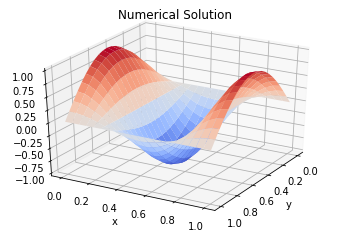

In [6]:
# Testing the function which takes step size as input instead of number of grid points
a=3
x,y,U=scheme1_H(a, b1, rhs1,0.05, T=1)
plot_solution(x,y,U)

**Plotting function**

In [7]:
# Plotting function for two schemes and two solutions   
def plot_two(U1, U2, uexact1, uexact2, angle=-30, title1="Numerical 1", title2="Numerical 2", title3="Analytical 1",
             title4="Analytical 2", R_val=None, T_val=None, M=20, N=1000):
    if (R_val==None):
        R_val=np.ones(3)*1

    if (T_val==None):
        T_val=np.ones(3)*1
    
    x1=np.linspace(0, R_val[0], len(U1[:,])) 
    t1=np.linspace(0, T_val[0], len(U1[0]))
    xx1, tt1 = np.meshgrid(x1, t1)
    x2=np.linspace(0, R_val[1], len(U2[:,])) 
    t2=np.linspace(0, T_val[1], len(U2[0]))
    xx2, tt2 = np.meshgrid(x2, t2)

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(17, 4), subplot_kw={"projection": "3d"})
    ax[0].plot_surface(tt1, xx1, U1, cmap=cm.coolwarm)
    ax[0].view_init(azim=30)
    ax[0].set_title(title1)
    ax[0].set_xlabel('y')
    ax[0].set_ylabel('x')
    ax[0].set_zlabel('u')
    ax[1].plot_surface(tt2, xx2, U2, cmap=cm.coolwarm)
    ax[1].view_init(azim=30)
    ax[1].set_title(title2)
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('x')
    ax[1].set_zlabel('u')
    
    xs1 = np.linspace(0,1, M+1)
    ts1 = np.linspace(0,1, N+1)
    X1,T1 = np.meshgrid(xs1, ts1)
    Z1 = uexact1(X1, T1) # evaluation of the function on the grid
    ax[2].set_title(title3)
    ax[2].plot_surface(T1, X1, Z1, cmap=cm.coolwarm)
    ax[2].view_init(azim=30)
    ax[2].set_xlabel('y')
    ax[2].set_ylabel('x')
    ax[2].set_zlabel('u')
    
    xs2 = np.linspace(0,1, M+1)
    ts2 = np.linspace(0,1, N+1)
    X2,T2 = np.meshgrid(xs2, ts2)
    Z2 = uexact2(X2, T2) # evaluation of the function on the grid
    ax[3].set_title(title4)
    ax[3].plot_surface(T2, X2, Z2, cmap=cm.coolwarm)
    ax[3].view_init(azim=30)
    ax[3].set_xlabel('y')
    ax[3].set_ylabel('x')
    ax[3].set_zlabel('u')
    fig.tight_layout()

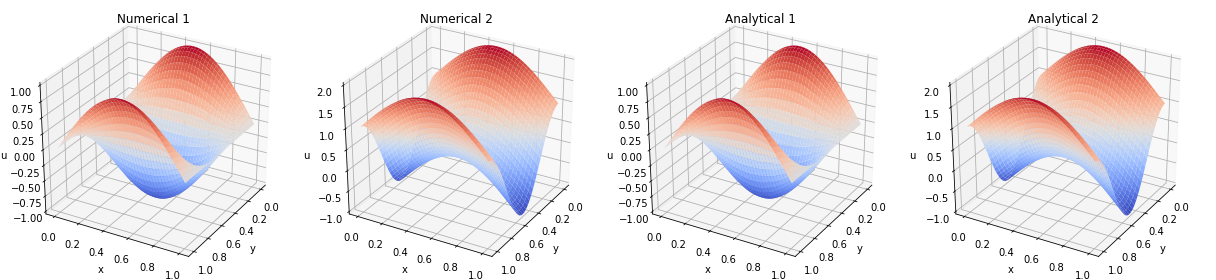

In [8]:
# Numerical and analytical plots of two different solutions
a=3
x1, y1, U1 = scheme1(a ,b1 , rhs1, 40, 40, 1)
x2, y2, U2 = scheme1(a ,b2 , rhs2, 40, 40, 1)

plot_two(U1, U2, uexact1, uexact2, M=40, N=40)

**Convergence/error plots**

Text(0.5, 0, 'Stepsize')

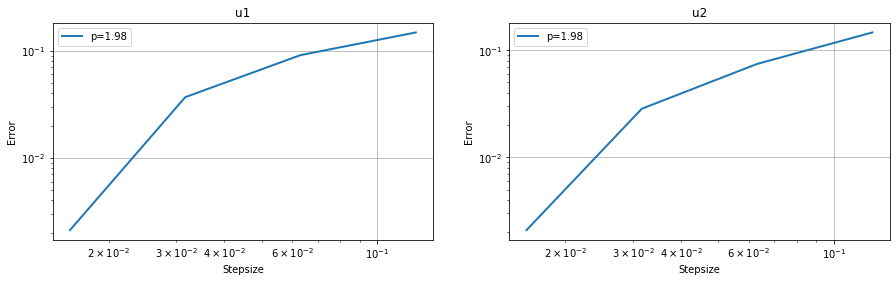

In [9]:
# Convergence rate/loglog-plot of error
H_list = np.logspace(-0.9, -1.8, 4)
a=3

# Initializing vectors to hold the errors
Error_list1 = np.zeros(len(H_list))
Error_list2 = np.zeros(len(H_list))

for i in range(len(H_list)):
    # Extracting the biggest error for some different step-sizes 
    # and using polyfit to find the order of convergence
    x1,y1,U1 = scheme1_H(a, b1, rhs1, H_list[i], T=1)
    xx1,yy1 = np.meshgrid(x1,y1)
    Error_list1[i] = np.max(np.abs(uexact1(xx1,yy1)-U1))
    
    x2,y2,U2 = scheme1_H(a, b2, rhs2, H_list[i], T=1)
    xx2,yy2 = np.meshgrid(x2,y2)
    Error_list2[i] = np.max(np.abs(uexact2(xx2,yy2)-U2))

    
order1 = np.polyfit(np.log(H_list),np.log(Error_list1),1)[0]    
order2 = np.polyfit(np.log(H_list),np.log(Error_list2),1)[0]
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    
ax[0].loglog(H_list,Error_list1,label='p={:.2f}'.format(order1))
ax[0].legend()
ax[0].set_title("u1")
ax[0].set_ylabel("Error")
ax[0].set_xlabel("Stepsize")
    
ax[1].loglog(H_list,Error_list2,label='p={:.2f}'.format(order2))
ax[1].legend()
ax[1].set_title("u2")
ax[1].set_ylabel("Error")
ax[1].set_xlabel("Stepsize")

**Irrational r and irregular grid** 

In [10]:
# problem 1d
def oppg1d(M, a, r, exact, rhs):  

    # step sizes in x, y and d2 directions
    h = 1/M
    k = np.abs(r)*h
    m = np.sqrt(h**2 + k**2)

    # initialize grid
    x = np.arange(0, 1+h, h)
    y = np.arange(0, 1+k, k)
    N = len(y) - 1
    grid = np.array([0, 0])

    # fill the grid, except at upper boundary
    for i in range(N+1):
        for j in range(M+1):
            grid = np.vstack((grid, [x[j], y[i]]))
    grid = grid[1:-M-1]

    # create upper boundary 
    for t in range(len(grid)):
        Px, Py = grid[t]
        if Py == y[-2]:
            d = (1-Py)*h/k
            if Px != 0 and Px != 1:
                grid = np.vstack((grid, [Px + d, 1]))

            else:
                grid = np.vstack((grid, [Px, 1]))

    # initialze stuff
    W = len(grid)
    A = np.zeros((W, W))
    b = np.zeros(W)

    # for every gridpoint
    for t in range(W):

        Px, Py = grid[t]

        # impose boundary condition
        if Px == 0:
            A[t][t] = 1
            b[t] = exact(Px, Py)
        elif Px == 1:
            A[t][t] = 1
            b[t] = exact(Px, Py)
        elif Py == 0:
            A[t][t] = 1
            b[t] = exact(Px, Py)
        elif Py == 1:
            A[t][t] = 1
            b[t] = exact(Px, Py)


        else:

            # if internal node is neighbor of the upper boundary
            if Py == y[-2]:

                # get coefficients
                eta = (1-Py)/k
                aP = -2*a/h**2
                aW = a/h**2
                aE = a/h**2
                bP = -2/m**2 * 1/eta * (1+r**2)
                bSW = 2/m**2 * 1/(1+eta) * (1+r**2)
                bNE = 2/m**2 * 1/(eta*(1+eta)) * (1+r**2)

                # locate neighboring nodes
                w = np.where(np.all(np.isclose(grid, [Px - h, Py]), axis = 1))[0][0]
                e = np.where(np.all(np.isclose(grid, [Px + h, Py]), axis = 1))[0][0]
                ne = np.where(np.all(np.isclose(grid, [Px + eta*h, 1]), axis = 1))[0][0]
                sw = np.where(np.all(np.isclose(grid, [Px - h, Py - k]), axis = 1))[0][0]

                # fill in matrix
                A[t][t] = -aP -bP
                A[t][w] = -aW
                A[t][e] = -aE
                A[t][ne] = -bNE
                A[t][sw] = -bSW

            # if node is elsewhere, run the normal scheme
            else:

                aP = -2*a/h**2
                aW = a/h**2
                aE = a/h**2
                bP = -2/h**2 
                bSW = 1/h**2
                bNE = 1/h**2

                w  = np.where(np.all(np.isclose(grid, [Px - h, Py]), axis = 1))[0][0]
                e  = np.where(np.all(np.isclose(grid, [Px + h, Py]), axis = 1))[0][0]
                ne = np.where(np.all(np.isclose(grid, [Px + h, Py + k]), axis = 1))[0][0]
                sw = np.where(np.all(np.isclose(grid, [Px - h, Py - k]), axis = 1))[0][0]

                A[t][t]  = -aP -bP
                A[t][w]  = -aW
                A[t][e]  = -aE
                A[t][ne] = -bNE
                A[t][sw] = -bSW

            # impose internal condition
            b[t] = -rhs(Px, Py, a, r)

    # obtain solution
    sol = np.linalg.solve(A, b)

    return sol, grid

In [11]:
# function for plotting solution of 1d
def plotSolution(M, a, r, exact, rhs):
    sol, grid = oppg1d(M, a, r, exact, rhs)

    # plot solution
    fig = plt.figure(figsize = (14,8))
    ax = fig.add_subplot(projection='3d')
    #ax.view_init(azim=0, elev=30)
    ax.plot_trisurf(grid[:, 0], grid[:, 1], sol, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z');

In [12]:
# exact solution
def F(x, y):
    return np.sin(np.pi*x) + np.cos(2*np.pi*y)

# right hand side
def LF(x, y, a, r):
    return -(a+1)*np.pi**2*np.sin(np.pi*x) - 4*r**2*np.pi**2*np.cos(2*np.pi*y)

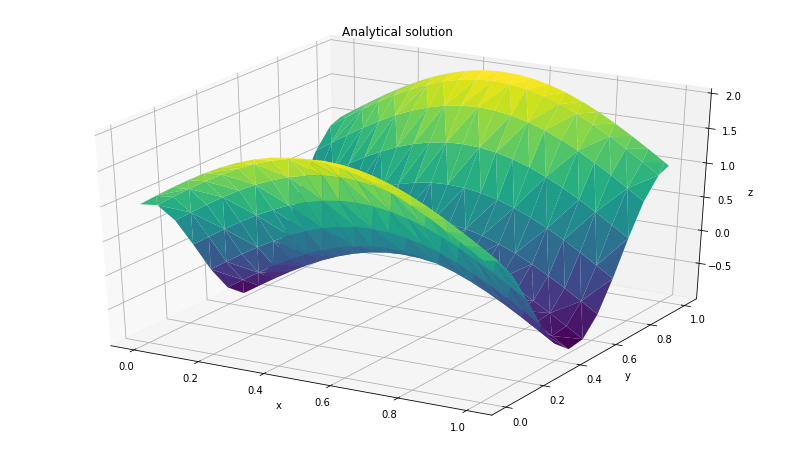

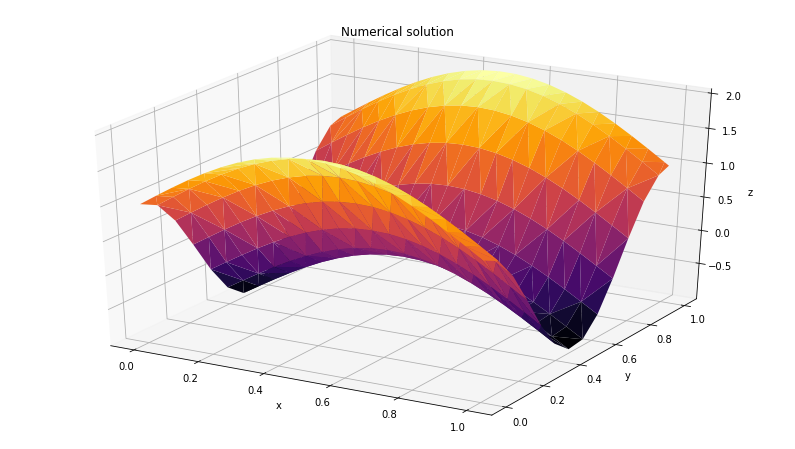

In [13]:
# plot exact and numerical solutions

SOL, GRID = oppg1d(20, 1, np.pi/2, F, LF)
EXACT = F(GRID[:, 0], GRID[:, 1])


fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(GRID[:, 0], GRID[:, 1], EXACT, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Analytical solution");

fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(GRID[:, 0], GRID[:, 1], SOL, cmap='inferno')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Numerical solution");

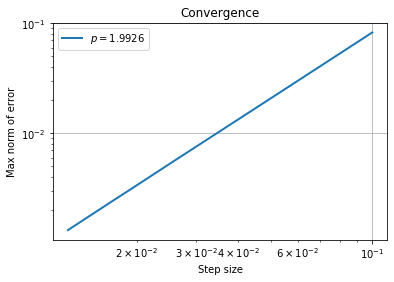

In [14]:
# check convergence order

Ms = np.array([10, 20, 40, 50, 60, 70, 80])
Q = len(Ms)
ers = np.zeros(Q)

for i in range(Q):
    SOLL, GRIDD = oppg1d(Ms[i], 1, np.e/2, F, LF)[:2]
    error = np.max(np.abs(F(GRIDD[:, 0], GRIDD[:, 1]) - SOLL))
    ers[i] = error

hs = 1/Ms
order = np.polyfit(np.log(1/Ms), np.log(ers), deg = 1)[0]
plt.loglog(hs, ers, label = f"$p = {np.round(order, 4)}$")
plt.title("Convergence")
plt.xlabel("Step size")
plt.ylabel("Max norm of error")
plt.legend()
plt.show()

**First quadrant unit disk, two methods**

In [15]:
# PROBLEM 2
# -------- #
 
# method where points on boundary of domain are added to grid
def method1(M, f, b1, b2, b3):
  
    # INPUT: number of points in x and y diractions

    # x and y values
    x = np.linspace(0, 1, M+1)
    y = np.linspace(0, 1, M+1)

    # create grid on quarter disk
    grid = np.array([0, 0])
    h = 1/M
    for i in range(len(x)):
        for j in range(len(y)):
            if x[i]**2 + y[j]**2 < 1:
                grid = np.vstack((grid, [x[j], y[i]]))
    grid = grid[1:, :]

    for xi in x[1:]:
        p = [xi, np.sqrt(1-xi**2)]
        grid = np.vstack((grid, p))

    for yi in y[1:]:
        p = [np.sqrt(1-yi**2), yi]
        grid = np.vstack((grid, p))

    # initialize
    N = len(grid)
    U = np.zeros(N)
    A = np.zeros((N, N))
    b = np.zeros(N)

    # for every gridpoint
    for k in range(len(grid)):

        # get x and y coordinates
        Px, Py = grid[k]

        # check if point is at left boundary
        if Px == 0: #or Py == 0 or np.abs(Px**2 + Py**2 - 1) < 10**-8:

          # impose boundary condition (zero everywhere)
            A[k][k] = 1
            b[k] = b1(Py)

        # check if point is at lower boundary
        elif Py == 0: #or Py == 0 or np.abs(Px**2 + Py**2 - 1) < 10**-8:

            # impose lower boundary condition
            A[k][k] = 1
            b[k] = b2(Px)

        # check if point is at quarter circle boundary
        elif np.abs(Px**2 + Py**2 - 1) < 10**-8:

            # impose boundary condition along quarter circle
            A[k][k] = 1
            b[k] = b3(Px, Py)

        # if point is in interior
        else:

            # calculate fraction of step size to neighbor point in east and north 
            eta_1 = np.min([ (np.sqrt(1 - Py**2) - Px)/h, 1])
            eta_2 = np.min([ (np.sqrt(1 - Px**2) - Py)/h, 1])

            # calculate coefficients for scheme
            aW =  2/h**2 * 1 / (1 + eta_1)
            aP = -2/h**2 * 1 / eta_1
            aE =  2/h**2 * 1 / (eta_1*(1 + eta_1))
            bN =  2/h**2 * 1 / (eta_2*(1 + eta_2))
            bP = -2/h**2 * 1 / eta_2
            bS =  2/h**2 * 1 / (1 + eta_2)

            # get indeces of neghboring points
            w = np.where(np.all(np.isclose(grid, [Px - h, Py]), axis = 1))[0][0]
            e = np.where(np.all(np.isclose(grid, [Px + eta_1*h, Py]), axis = 1))[0][0]
            n = np.where(np.all(np.isclose(grid, [Px, Py + eta_2*h]), axis = 1))[0][0]
            s = np.where(np.all(np.isclose(grid, [Px, Py - h]), axis = 1))[0][0]

            # fill the matrix
            A[k][k] = -aP -bP
            A[k][s] = -bS
            A[k][n] = -bN
            A[k][w] = -aW
            A[k][e] = -aE

            # impose interior condition
            b[k] = f(Px, Py)

    # obtain solution
    sol = np.linalg.solve(A, b)

    # plot solution
    fig = plt.figure(figsize = (14,8))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(azim=70)
    ax.plot_trisurf(grid[:, 0], grid[:, 1], sol, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z');

In [16]:
# define some boundary conditions

# lower boundary
def b1(y):
    return 0*np.sin(2*np.pi*y)

# left boundary
def b2(x):
    return 0*np.sin(2*np.pi*x)

# circle boundary
def b3(x, y):
    t = np.arctan(y/x)
    return 0*2*t

# right hand side
def f(x, y):
    return 1

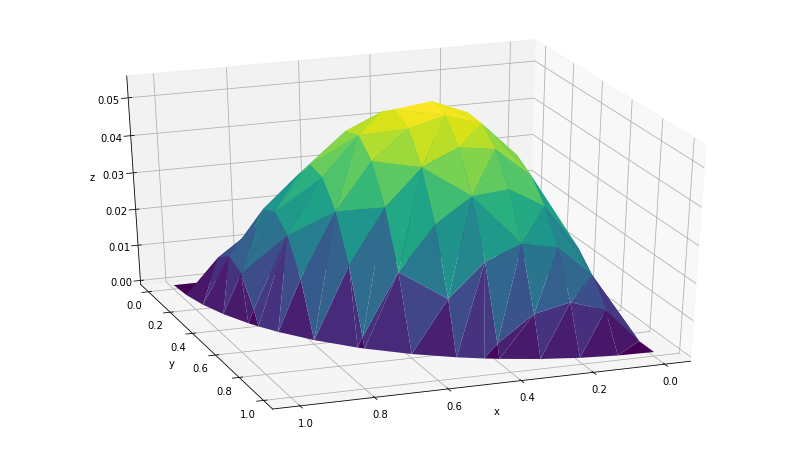

In [17]:
# make a plot for first method
method1(10, f, b1, b2, b3)

In [18]:
# fatten the boundary method
def method2(M, r):

    h = 1/M
    x = np.linspace(0, 1, M+1)
    y = np.linspace(0, 1, M+1)

    grid = np.array([0,0])
    for i in range(M+1):
        for j in range(M+1):
            if x[i]**2 + y[j]**2 <= (1+r)**2:
                grid = np.vstack((grid, [x[i], y[j]]))
    grid = grid[1:]

    # initialize
    N = len(grid)
    U = np.zeros(N)
    A = np.zeros((N, N))
    b = np.zeros(N)

    # for every gridpoint
    for k in range(N):

        # get x and y coordinates
        Px, Py = grid[k]

        # check if point is at boundary
        if Px == 0 or Py == 0 or (1 <= Px**2 + Py**2 and Px**2 + Py**2 <= (1+r)**2):
          # impose boundary condition (zero everywhere)
            A[k][k] = 1
            b[k] = 1

        # if point is in interior
        else:

            # locate neghboring points
            w = np.where(np.all(np.isclose(grid, [Px - h, Py]), axis = 1))[0][0]
            e = np.where(np.all(np.isclose(grid, [Px + h, Py]), axis = 1))[0][0]
            n = np.where(np.all(np.isclose(grid, [Px, Py + h]), axis = 1))[0][0]
            s = np.where(np.all(np.isclose(grid, [Px, Py - h]), axis = 1))[0][0]

            # fill the matrix
            A[k][k] =  4
            A[k][s] = -1
            A[k][n] = -1
            A[k][w] = -1
            A[k][e] = -1

            # impose interior condition (negative laplacian is 1 everywhere)
            b[k] = 1

    # obtain solution
    sol = np.linalg.solve(A, b)

    # plot solution
    fig = plt.figure(figsize = (14,8))
    ax = fig.add_subplot(projection='3d')
    #ax.view_init(azim=0, elev=90)
    ax.plot_trisurf(grid[:, 0], grid[:, 1], sol, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z');

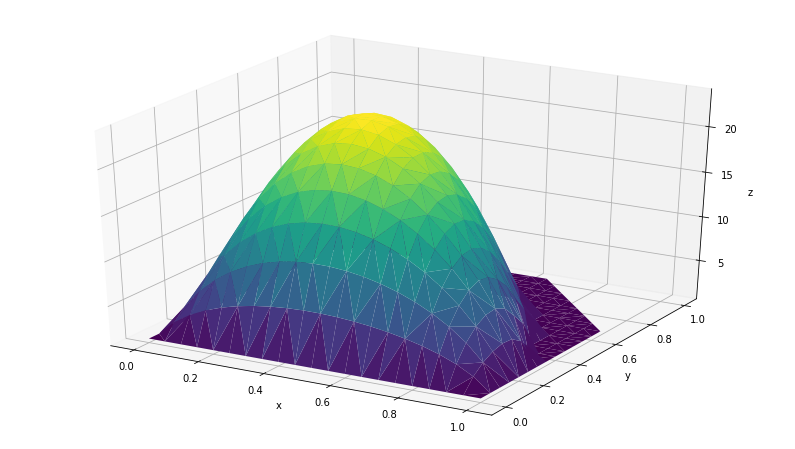

In [19]:
# make plot for method 2 with desired boundary thickness
method2(20, 0.2)

# Part 2: A variable coefficient transport equation

In [20]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1) + d*np.diag(e) + w*np.diag(e[1:],1)
    return A 

In [21]:
def a1(x):
    return (x-1/3)*(x-2/3)

def a_div(x):
    return 2*x-1

def r_pos(r):
    return np.fmax(r, 0)

def r_neg(r):
    return r_pos(-r)

def u_0(x):
    return 1- np.sin(2*np.pi*x)*x**2   

def u_02(x):
    return (x**2)/2    

def g(t,a):
    return u_0(-a(0)* t)  

def g2(t,a):
    return u_02(-a(0)* t)  

def uex(x,t,a, u_0):
    return  u_0(x-a(x)*t)  

def uex2(x,t,a, u_0):
    return  u_0(x - a(x)* t)

def uex3(x,t,a, u_0):
    return np.cos(2*np.pi*x)*np.sin(2*np.pi*t)

def g3(t):
    return np.sin(2*np.pi*t)

def u_03(x):
    return 0

def RHS2(x,t,a):
    return 2*np.pi * np.cos(2*np.pi*x) * np.cos(2*np.pi*t) - a(x)*2*np.pi * np.sin(2*np.pi*x) * np.sin(2*np.pi*t)

def RHSx2(x,t,a, aDer):
    xDer = -4*np.pi**2 * np.sin(2*np.pi*x)*np.cos(2*np.pi*t) - 2*np.pi*aDer(x)*np.pi*np.sin(2*np.pi*x)*np.sin(2*np.pi*t)\
    - 4*np.pi*a(x) * np.cos(2*np.pi*x)*np.sin(2*np.pi*t)
    return xDer

def RHSt2(x,t,a):
    tDer = -4*np.pi**2 * np.cos(2*np.pi*x) *np.sin(2*np.pi*t) - 4*np.pi**2 * a(x) * np.sin(2*np.pi*x)*np.cos(2*np.pi*t)
    return tDer   

In [22]:
def upwind(a, r_pos, r_neg, u_0, g, M, N, T):
    
    x = np.linspace(0,1,M+1)
    t = np.linspace(0,T,N+1)
    
    h = 1/M
    k = T/N
    
    r = a(x)*(k/h)

    U = np.zeros((M+1,N+1))
    
    r_p = np.vectorize(r_pos)(r)
    r_n = np.vectorize(r_neg)(r)
    
    
    A=diags([r_p[1:], 1-r_p[:] -r_n[:], r_n[:-1]], [-1,0,1]).toarray()
    
    U[:,0] = np.vectorize(u_0)(x)
    
    
    for n in range(N):
        U[:,n+1] = A.dot(U[:,n])
        U[0,n+1] = g(t[n+1],a)

   
    return x,t,U

In [23]:
# Plotting functions

def plot_solution(x, t, U, txt='Numerical Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={'projection' : '3d'})
    T, X = np.meshgrid(t,x)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt)
    
def plot_exact_solution(f, a, u_0, txt = "Analytical solution"):
    M=1000
    N=1000
    xs = np.linspace(0,1,M+1)
    ts = np.linspace(0,1,N+1)
    fig=plt.figure()
    ax = fig.gca(projection='3d')
    X,T = np.meshgrid(xs, ts) # grid of point
    Z = f(X, T, a, u_0) # evaluation of the function on the grid
    ax.plot_surface(T, X, Z, cmap=cm.coolwarm)
    ax.view_init(azim=30)
    plt.title(txt)

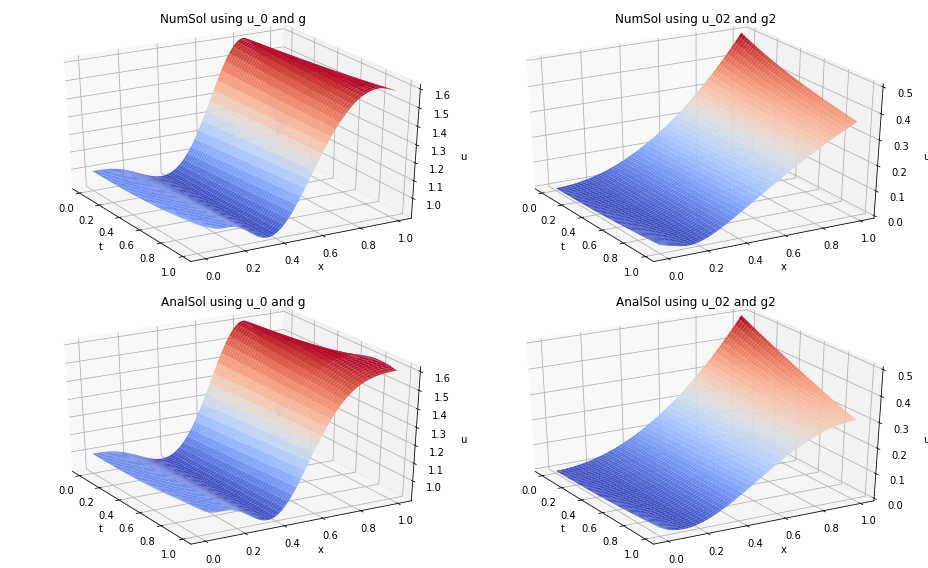

In [24]:
x1,t1,U1=upwind(a1, r_pos, r_neg, u_0, g, 1000, 1000, 1)
x2,t2,U2=upwind(a1, r_pos, r_neg, u_02, g2, 1000, 1000, 1)

angle=-30
tt1, xx1 = np.meshgrid(t1, x1)
tt2, xx2 = np.meshgrid(t2, x2)

tt6, xx6 = np.meshgrid(t1, x1)
Z=uex(xx6,tt6,a1, u_0)
Z2=uex(xx6,tt6,a1, u_02)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13, 8), subplot_kw={"projection": "3d"})
ax[0][0].plot_surface(tt1, xx1, U1, cmap=cm.coolwarm)
ax[0][0].view_init(azim=angle)
ax[0][0].set_title("NumSol using u_0 and g")
ax[0][0].set_xlabel('t')
ax[0][0].set_ylabel('x')
ax[0][0].set_zlabel('u')
ax[0][1].plot_surface(tt2, xx2, U2, cmap=cm.coolwarm)
ax[0][1].view_init(azim=angle)
ax[0][1].set_title("NumSol using u_02 and g2")
ax[0][1].set_xlabel('t')
ax[0][1].set_ylabel('x')
ax[0][1].set_zlabel('u')
ax[1][0].plot_surface(tt1, xx1, Z, cmap=cm.coolwarm)
ax[1][0].view_init(azim=angle)
ax[1][0].set_title("AnalSol using u_0 and g")
ax[1][0].set_xlabel('t')
ax[1][0].set_ylabel('x')
ax[1][0].set_zlabel('u')
ax[1][1].plot_surface(tt1, xx1, Z2, cmap=cm.coolwarm)
ax[1][1].view_init(azim=angle)
ax[1][1].set_title("AnalSol using u_02 and g2")
ax[1][1].set_xlabel('t')
ax[1][1].set_ylabel('x')
ax[1][1].set_zlabel('u')
fig.tight_layout()

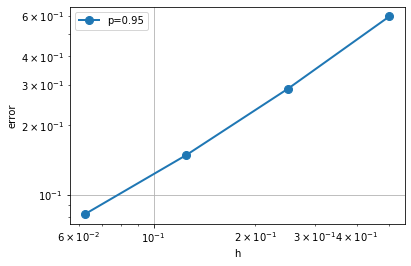

In [25]:
def convergence_h(u_exact, solver, P, a): 
    
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M=2
    for p in range(P):
        x, t, U = solver(a1, r_pos, r_neg, u_0, g, M=M, N=1000, T=1)
        Eh = u_exact(x,t[-1], a1, u_0) - U[:,-1]
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M*=2
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

H, E, p = convergence_h(uex, upwind, 4, a1)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();
plt.show()

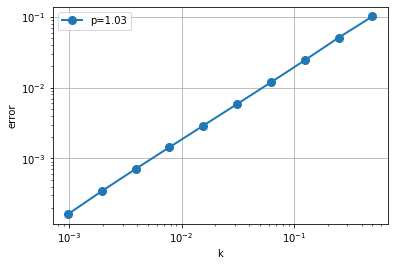

In [26]:
def convergence_k(u_exact, solver, P): 
    
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    N=2
    M=20
    
    x,t, U_ref = solver(a1,r_pos, r_neg, u_0, g, M=M, N=10000, T=1)
    for p in range(P):
        x, t, U = solver(a1, r_pos, r_neg, u_0, g, M=M, N=N, T=1)
        Eh = U_ref[:,-1] - U[:,-1]
        Hconv[p] = (t[1]-t[0])
        Econv[p] = np.max(np.abs(Eh))
        N*= 2
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

H, E, p = convergence_k(uex, upwind, 10)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('k')
plt.ylabel('error')
plt.legend();
plt.show()

In [27]:
# Lax-Wendroff with a right hand side
def lax_wendroff(a, a_div, r_pos, r_neg, u_0, g, M, N, T):
    
    x = np.linspace(0,1,M+1)
    t = np.linspace(0,T,N+1)
    
    h = 1/M
    k = T/N
    
    r = a(x)*k/h

    U = np.zeros((M+1,N+1))
    
    r_p = np.vectorize(r_pos)(r)
    r_n = np.vectorize(r_neg)(r)

    new_term = r*(1-1/2*k*a_div(x))
    v1 = 1/2*(new_term+r**2)
    d1 = 1-r**2
    w1 = 1/2*(r**2-new_term)
    
    B=diags([v1[1:], d1[:], w1[:-1]], [-1,0,1]).toarray()
    
    # Initial and boundary conditions
    U[:,0] = np.vectorize(u_0)(x)
    U[0,:] = np.vectorize(g)(t)
    
    for n in range(N):
        U[:, n+1] = B.dot(U[:,n]) + RHS2(x,t[n],a)*k + 1/2*k**2 * RHSt2(x, t[n], a) - 1/2*a(x)*k**2*RHSx2(x,t[n],a1, a_div)
        U[0,n+1] = g(t[n+1])
        U[M,n+1] = U[M-1, n+1]
    
    return x,t,U  

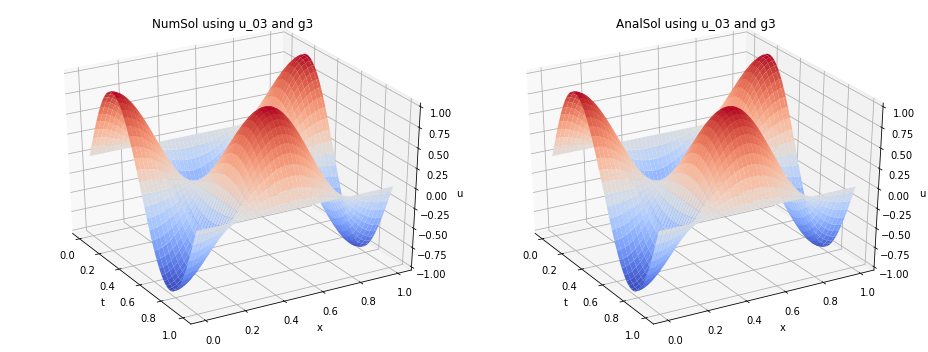

In [28]:
x,t,U=lax_wendroff(a1,a_div, r_pos, r_neg, u_03, g3, 1000, 1000, 1)

#plot_solution(x,t,U)

#plot_exact_solution(uex3, a1, u_03)
tt1, xx1 = np.meshgrid(t, x)
Z=uex3(xx1,tt1,a1, u_03)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), subplot_kw={"projection": "3d"})
ax[0].plot_surface(tt1, xx1, U, cmap=cm.coolwarm)
ax[0].view_init(azim=angle)
ax[0].set_title("NumSol using u_03 and g3")
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[0].set_zlabel('u')
ax[1].plot_surface(tt1, xx1, Z, cmap=cm.coolwarm)
ax[1].view_init(azim=angle)
ax[1].set_title("AnalSol using u_03 and g3")
ax[1].set_xlabel('t')
ax[1].set_ylabel('x')
ax[1].set_zlabel('u')
fig.tight_layout()

In [29]:
# Lax-Wendroff without a right hand side
def g4(t):
    return u_0(-a1(0)* t) 

def lax_wendroff2(a, a_div, r_pos, r_neg, u_0, g, M, N, T):
    
    x = np.linspace(0,1,M+1)
    t = np.linspace(0,T,N+1)
    
    h = 1/M
    k = T/N
    
    r = a(x)*k/h

    U = np.zeros((M+1,N+1))
    
    r_p = np.vectorize(r_pos)(r)
    r_n = np.vectorize(r_neg)(r)

    new_term = r*(1-1/2*k*a_div(x))
    v1 = 1/2*(new_term+r**2)
    d1 = 1-r**2
    w1 = 1/2*(r**2-new_term)
    
    B=diags([v1[1:], d1[:], w1[:-1]], [-1,0,1]).toarray()
    
    # Initial and boundary conditions
    U[:,0] = np.vectorize(u_0)(x)
    U[0,:] = np.vectorize(g)(t)
    
    for n in range(N):
        U[:, n+1] = B.dot(U[:,n]) 
        U[0,n+1] = g(t[n+1])
        U[M,n+1] = U[M-1, n+1]
    
    return x,t,U  

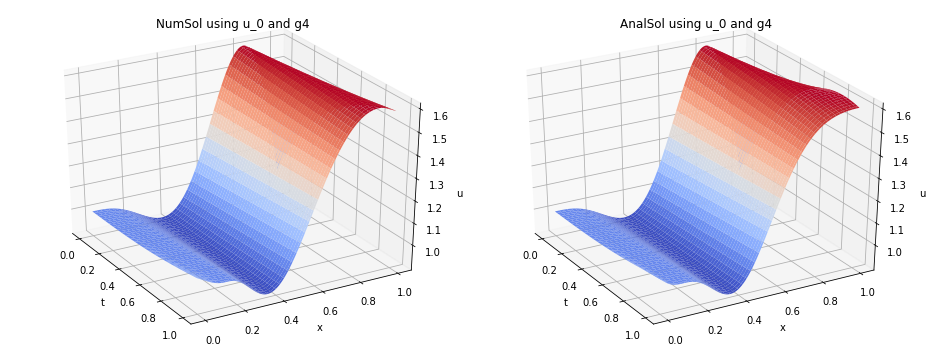

In [30]:
x,t,U=lax_wendroff2(a1, a_div, r_pos, r_neg, u_0, g4, 1000, 1000, 1)

tt1, xx1 = np.meshgrid(t, x)
Z=uex(xx1,tt1,a1, u_0)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), subplot_kw={"projection": "3d"})
ax[0].plot_surface(tt1, xx1, U, cmap=cm.coolwarm)
ax[0].view_init(azim=angle)
ax[0].set_title("NumSol using u_0 and g4")
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[0].set_zlabel('u')
ax[1].plot_surface(tt1, xx1, Z, cmap=cm.coolwarm)
ax[1].view_init(azim=angle)
ax[1].set_title("AnalSol using u_0 and g4")
ax[1].set_xlabel('t')
ax[1].set_ylabel('x')
ax[1].set_zlabel('u')
fig.tight_layout()

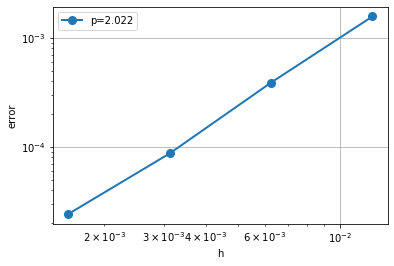

In [31]:
def convergence_h2(u_exact, solver, P): 
    
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 80
    for p in range(P):
        x, t, U = solver(a1, a_div, r_pos, r_neg, u_03, g3, M=M, N=10000, T=1)
        Eh = u_exact(x,t[-1], a1, u_03) - U[:,-1]
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M *= 2
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

H, E, p = convergence_h2(uex3, lax_wendroff, 4)
plt.loglog(H,E,'o-', label='p={:.3f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();
plt.show()

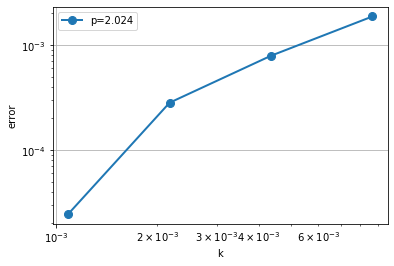

In [32]:
def convergence_k2(u_exact, solver, P): 
    
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    N=115
    
    for p in range(P):
        x, t, U = solver(a1, a_div, r_pos, r_neg, u_03, g3, M=100, N=N, T=1)
        Eh = U_ref[:,-1] - U[:,-1]
        Hconv[p] = (t[1]-t[0])
        Econv[p] = np.max(np.abs(Eh))
        N*= 2
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

x,t, U_ref = lax_wendroff(a1, a_div, r_pos, r_neg, u_03, g3, M=100, N=1000, T=1)

H, E, p = convergence_k2(uex3, lax_wendroff, 4)
plt.loglog(H,E,'o-', label='p={:.3f}'.format(p))
plt.grid('on')
plt.xlabel('k')
plt.ylabel('error')
plt.legend();
plt.show()